In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from scipy.special import gamma
from scipy.stats import moment, kurtosis, entropy

from collections import defaultdict

from itertools import product, combinations

import pickle
from joblib import Parallel, delayed

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')

ROOT_PATH = 'D:/Jupyter/pred_antonova/time_series_prediction/'

In [967]:
class Wishart:
    def __init__(self, wishart_neighbors, significance_level):
        self.wishart_neighbors = wishart_neighbors  # Number of neighbors
        self.significance_level = significance_level  # Significance level

    def fit(self, X):
        from sklearn.neighbors import KDTree
        kdt = KDTree(X, metric='euclidean')

        #add one because you are your neighb.
        distances, neighbors = kdt.query(X, k = self.wishart_neighbors + 1, return_distance = True)
        neighbors = neighbors[:, 1:]


        distances = distances[:, -1]
        indexes = np.argsort(distances)
        
        size, dim = X.shape

        self.object_labels = np.zeros(size, dtype = int) - 1

        #index in tuple
        #min_dist, max_dist, flag_to_significant
        self.clusters = np.array([(1., 1., 0)])
        self.clusters_to_objects = defaultdict(list)
        # print('Start clustering')

        for index in indexes:
            neighbors_clusters =\
                np.concatenate([self.object_labels[neighbors[index]], self.object_labels[neighbors[index]]])
            unique_clusters = np.unique(neighbors_clusters).astype(int)
            unique_clusters = unique_clusters[unique_clusters != -1]


            if len(unique_clusters) == 0:
                self._create_new_cluster(index, distances[index])
            else:
                max_cluster = unique_clusters[-1]
                min_cluster = unique_clusters[0]
                if max_cluster == min_cluster:
                    if self.clusters[max_cluster][-1] < 0.5:
                        self._add_elem_to_exist_cluster(index, distances[index], max_cluster)
                    else:
                        self._add_elem_to_noise(index)
                else:
                    my_clusters = self.clusters[unique_clusters]
                    flags = my_clusters[:, -1]
                    if np.min(flags) > 0.5:
                        self._add_elem_to_noise(index)
                    else:
                        significan = np.power(my_clusters[:, 0], -dim) - np.power(my_clusters[:, 1], -dim)
                        significan *= self.wishart_neighbors
                        significan /= size
                        significan /= np.power(np.pi, dim / 2)
                        significan *= gamma(dim / 2 + 1)
                        significan_index = significan >= self.significance_level

                        significan_clusters = unique_clusters[significan_index]
                        not_significan_clusters = unique_clusters[~significan_index]
                        significan_clusters_count = len(significan_clusters)
                        if significan_clusters_count > 1 or min_cluster == 0:
                            self._add_elem_to_noise(index)
                            self.clusters[significan_clusters, -1] = 1
                            for not_sig_cluster in not_significan_clusters:
                                if not_sig_cluster == 0:
                                    continue

                                for bad_index in self.clusters_to_objects[not_sig_cluster]:
                                    self._add_elem_to_noise(bad_index)
                                self.clusters_to_objects[not_sig_cluster].clear()
                        else:
                            for cur_cluster in unique_clusters:
                                if cur_cluster == min_cluster:
                                    continue

                                for bad_index in self.clusters_to_objects[cur_cluster]:
                                    self._add_elem_to_exist_cluster(bad_index, distances[bad_index], min_cluster)
                                self.clusters_to_objects[cur_cluster].clear()

                            self._add_elem_to_exist_cluster(index, distances[index], min_cluster)

        return self.clean_data()

    def clean_data(self):
        unique = np.unique(self.object_labels)
        index = np.argsort(unique)
        if unique[0] != 0:
            index += 1
        true_cluster = {unq :  index for unq, index in zip(unique, index)}
        result = np.zeros(len(self.object_labels), dtype = int)
        for index, unq in enumerate(self.object_labels):
            result[index] = true_cluster[unq]
        return result

    def _add_elem_to_noise(self, index):
        self.object_labels[index] = 0
        self.clusters_to_objects[0].append(index)

    def _create_new_cluster(self, index, dist):
        self.object_labels[index] = len(self.clusters)
        self.clusters_to_objects[len(self.clusters)].append(index)
        self.clusters = np.append(self.clusters, [(dist, dist, 0)], axis = 0)

    def _add_elem_to_exist_cluster(self, index, dist, cluster_label):
        self.object_labels[index] = cluster_label
        self.clusters_to_objects[cluster_label].append(index)
        self.clusters[cluster_label][0] = min(self.clusters[cluster_label][0], dist)
        self.clusters[cluster_label][1] = max(self.clusters[cluster_label][1], dist)

In [4]:
n_train = 10_000
n_test = 1_000 + 300 # to get test set of 1000, 300 - про запас
n_passed = 3_000
n_valid = 2_000

with open(ROOT_PATH + 'data/lorenz.dat', 'rb') as f:
    Y = pickle.load(f)

Y1 = np.array(Y[n_passed:n_passed + n_train]).reshape(-1)
Y2 = np.array(Y[n_passed + n_train:n_passed + n_train + n_test]).reshape(-1)
Y3 = np.array(Y[n_passed + n_train + n_test:n_passed + n_train + n_test + n_valid]).reshape(-1)

In [1395]:
motif_clustering_params = {
    'beta': 0.2,
    'mc_method': 'db'
}

prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

non_pred_model_prediction = predictor.ForcedPredictionNPM()
base_model = predictor.LimitClusterSizeNPM(0.5, 5)
non_pred_model_healing = predictor.WeirdPatternsNPM(Y1, eps0=0.1, base_non_pred_model=base_model)

predictor_main = predictor.TimeSeriesPredictor([], non_pred_model_prediction)

In [1396]:
cluster_motifs = predictor_main.cluster_motifs(Y1)
'''
with open(ROOT_PATH + 'mine/cluster_motifs.dat', 'wb') as f:
    pass
with open(ROOT_PATH + 'mine/cluster_motifs.dat', 'ab') as f:
    pickle.dump(cluster_motifs, f)
'''

"\nwith open(ROOT_PATH + 'mine/cluster_motifs.dat', 'wb') as f:\n    pass\nwith open(ROOT_PATH + 'mine/cluster_motifs.dat', 'ab') as f:\n    pickle.dump(cluster_motifs, f)\n"

In [1397]:
Y_pred = np.append(Y1[-100:], Y2[:100])
unified_predictions, possible_predictions = predictor_main.predict(Y_pred, 100, **prediction_params)

'''
with open(ROOT_PATH + 'mine/unified_predictions.dat', 'wb') as f:
    pass
with open(ROOT_PATH + 'mine/unified_predictions.dat', 'ab') as f:
    pickle.dump(unified_predictions, f)

with open(ROOT_PATH + 'mine/possible_predictions.dat', 'wb') as f:
    pass
with open(ROOT_PATH + 'mine/possible_predictions.dat', 'ab') as f:
    pickle.dump(possible_predictions, f)
'''

"\nwith open(ROOT_PATH + 'mine/unified_predictions.dat', 'wb') as f:\n    pass\nwith open(ROOT_PATH + 'mine/unified_predictions.dat', 'ab') as f:\n    pickle.dump(unified_predictions, f)\n\nwith open(ROOT_PATH + 'mine/possible_predictions.dat', 'wb') as f:\n    pass\nwith open(ROOT_PATH + 'mine/possible_predictions.dat', 'ab') as f:\n    pickle.dump(possible_predictions, f)\n"

In [67]:
healing_params = {
    'healing_up_method' : 'db', 
    'weighted_up' : True,  
    # {'double_clustering', 'weighred_average', 'factor', 
    # 'pattern_length', 'pattern_length_dist', 'dist', 
    # 'dist_factor'}
    'weight_method' : 'factor', 
    'clear_noise' : False,
    'factor' : 0.7,
    'alg_type' : 's',
    'mc_method' : 'db',
    'beta' : 0.2,
    'fixed_points' : False,
    'healing_motif_match_eps': 0.01,
    'eps_stop' : 0.05
}

healed_unififed_predictions, possible_unified_predictions = predictor_main.self_healing(Y_pred, 100, return_n_iterations=False, \
    unified_predictions=unified_predictions, \
    possible_predictions=possible_predictions, \
    fixed_points_idx=[],
    **healing_params)

with open(ROOT_PATH + 'mine/healed_unififed_predictions.dat', 'wb') as f:
    pass
with open(ROOT_PATH + 'mine/healed_unififed_predictions.dat', 'ab') as f:
    pickle.dump(healed_unififed_predictions, f)

with open(ROOT_PATH + 'mine/possible_unified_predictions.dat', 'wb') as f:
    pass
with open(ROOT_PATH + 'mine/possible_unified_predictions.dat', 'ab') as f:
    pickle.dump(possible_unified_predictions, f)

In [ ]:
from scipy.interpolate import interp1d

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
h = 100
x = [i for i in range(1, h + 1)]

interp = interp1d(x=x, y=Y2[100:h + 100], kind='cubic', bounds_error=False)
xi_true = np.linspace(1, 100, 1000)
yi_true = interp(xi_true)
sns.lineplot(x=xi_true, y=yi_true, ax=ax, color='blue', alpha=0.5)

predictable = np.argwhere(unified_predictions[100:] != 'N').reshape(1, -1)[0]
y = np.take(unified_predictions[100:], predictable).astype(float)
x1 = np.take(x, predictable)
interp = interp1d(x=x1, y=y, kind='cubic', bounds_error=False)
xi = np.linspace(1, predictable[-1], 1000)
yi = interp(xi)
sns.lineplot(x=xi, y=yi, color='green', ax=ax)

predictable = np.argwhere(healed_unififed_predictions != 'N').reshape(1, -1)[0]
y = np.take(healed_unififed_predictions, predictable).astype(float)
x1 = np.take(x, predictable)
interp = interp1d(x=x1, y=y, kind='cubic', bounds_error=False)
xi = np.linspace(1, predictable[-1], 1000)
yi = interp(xi)
sns.lineplot(x=xi, y=yi, color='red', ax=ax)

In [1285]:
def self_healing_window(train_array, heal_array, not_predictable_point_label = 'N'):
    healed_array = heal_array
    nnp_label = not_predictable_point_label

    n = len(train_array)
    k = len(heal_array)

    checked_windows = []

    for i in range(n - k):
        error = 0
        
        for j in range(k):
            if heal_array[j] != nnp_label:
                error += (train_array[i + j] - heal_array[j]) ** 2
        
        checked_windows.append([i, error])
    
    best_window = min(checked_windows, key = lambda x: x[1])

    for i in range(k):
        if heal_array[i] == nnp_label:
            heal_array[i] = train_array[i + best_window[0]]

    return healed_array

In [1358]:
import networkx as nx
from tqdm import tqdm

class predictor_markov_chain():
    def __init__(self):
        self.graph = None
        self.train_array = None
        self.max_pattern_len = None

    def fit_train_array(self, train_array):
        self.train_array = train_array

    def produce_chain_diff(self, max_pattern_len = 100, round_ = 1, mode = 'ind'):

        if self.train_array.all() == None:
            raise ValueError('Train array is empty')

        if len(self.train_array) < max_pattern_len:
            raise ValueError('Max pattern length is greater than train array length')

        G = nx.DiGraph()
        n = len(self.train_array)
        G.add_node(0, diff = None, level = 0)

        for i in tqdm(range(n - max_pattern_len)):
            current_node = 0

            for j in range(max_pattern_len - 1):
                diff = round(self.train_array[i + j] - self.train_array[i + j + 1], round_)

                if mode == 'ind':
                    current_level = [i for i in G.nodes if G.nodes[i]['level'] == j + 1]
                elif mode == 'uni':
                    current_level = [i for i in G.neighbors(current_node)]

                if diff not in [G.nodes[i]['diff'] for i in current_level]:
                    new_node = len(G)
                    G.add_node(new_node, diff = diff, level = j + 1)
                    G.add_edge(current_node, new_node, weight = 1)
                    current_node  = new_node
                
                else:
                    correct_node = [i for i in current_level if G.nodes[i]['diff'] == diff][0]
                    
                    if G.has_edge(current_node, correct_node):
                        G[current_node][correct_node]['weight'] += 1
                    
                    else:
                        G.add_edge(current_node, correct_node, weight = 1)

                    if G.nodes[correct_node]['level'] - G.nodes[current_node]['level'] != 1:
                        print('Error')
                        
                    current_node = correct_node

    
        self.graph = G
        self.max_pattern_len = max_pattern_len
        pass

    def produce_chain_grad(self, max_pattern_len = 100, round_ = 1, mode = 'ind'):
        
        if self.train_array.all() == None:
            raise ValueError('Train array is empty')

        if len(self.train_array) < max_pattern_len:
            raise ValueError('Max pattern length is greater than train array length')

        G = nx.DiGraph()
        n = len(self.train_array)
        G.add_node(0, grad = None, level = None)

        for i in range(n - max_pattern_len):
            current_node = 0

            for j in range(max_pattern_len - 2):
                grad = round(self.train_array[i + j] - 2 * self.train_array[i + j + 1] + self.train_array[i + j + 2], round_)

                if mode == 'uni':
                    current_level = [i for i in G.nodes if G.nodes[i]['level'] == j + 1]
                elif mode == 'ind':
                    current_level = [i for i in G.neighbors(current_node)]

                if grad not in [G.nodes[i]['grad'] for i in current_level]:
                    new_node = len(G)
                    G.add_node(new_node, grad = grad, level = j + 1)
                    G.add_edge(current_node, new_node, weight = 1)
                    current_node = new_node
            
                else:
                    correct_node = [i for i in current_level if G.nodes[i]['grad'] == grad][0]

                    if G.has_edge(current_node, correct_node):
                        G[current_node][correct_node]['weight'] += 1
                
                    else:
                        G.add_edge(current_node, correct_node, weight = 1)
                
                    current_node = correct_node
        
        self.graph = G
        self.max_pattern_len = max_pattern_len
        pass

    def get_graph(self):
        return self.graph
    
    def get_max_pattern_len(self):
        return self.max_pattern_len
    
    def get_trajectory_diff(self,start_y, trajectory_len, power = 1):

        if self.graph == None:
            raise ValueError('Graph not founded')

        if trajectory_len > self.max_pattern_len:
            raise ValueError('Trajectory length > Max possible trajectory lenght')

        current_node = 0
        current_y = start_y
        trajectory = [start_y]

        for i in range(trajectory_len - 2):

            weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
            nodes = [i for i in self.graph[current_node]]
            weights = weights / weights.sum()

            if np.array(weights).sum() == 0:
                return trajectory

            next_node = np.random.choice(nodes, p = weights)
            current_y = current_y - self.graph.nodes[next_node]['diff']
            trajectory.append(current_y)
            current_node = next_node
            
        return trajectory

    def continue_trajectory_diff(self, trace, power = 1):
        trajectory = [trace[0]]
        current_node = 0

        for i in range(len(trace) - 1):
            diff = trace[i] - trace[i + 1]
            nodes = [(i, self.graph.nodes[i]['diff']) for i in self.graph.neighbors(current_node)]
            error = [(i, np.sqrt((j - diff) ** 2)) for i, j in nodes]
            next_node = min(error, key = lambda x: x[1])[0]

            trajectory.append(trajectory[i] - self.graph.nodes[next_node]['diff'])
            current_node = next_node
        
        current_y = trajectory[-1]

        for i in range(self.max_pattern_len - len(trace)):
            
             weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
             nodes = [i for i in self.graph[current_node]]
             weights = weights / weights.sum()

             next_node = np.random.choice(nodes, p = weights)
             current_y = current_y - self.graph.nodes[next_node]['diff']
             trajectory.append(current_y)
             current_node = next_node
            
        return trajectory

    def get_trajectory_grad(self, start_couple, trajectory_len, power = 1):

        if self.graph == None:
            raise ValueError('Graph not founded')

        if trajectory_len > self.max_pattern_len:
            raise ValueError('Trajectory length > Max possible trajectory lenght')

        trajectory = [start_couple[0], start_couple[1]]

        velocity = trajectory[0] - trajectory[1]
        current_y = trajectory[1]
        current_node = 0

        for i in range(trajectory_len - 3):
            
            weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
            nodes = [i for i in self.graph[current_node]]
            weights = weights / weights.sum()

            next_node = np.random.choice(nodes, p = weights)
            velocity = velocity - self.graph.nodes[next_node]['grad']
            current_y = current_y - velocity
            trajectory.append(current_y)
            current_node = next_node

        return trajectory
    
    def continue_trajectory_grad(self, trace, power = 1):
        trajectory = [trace[0], trace[1]]
        velocity = trace[0] - trace[1]
        current_node = 0

        for i in range(len(trace) - 2):
            grad = trace[i] - 2 * trace[i + 1] + trace[i + 2]
            nodes = [(i, self.graph.nodes[i]['grad']) for i in self.graph.neighbors(current_node)]
            error = [(i, np.sqrt(j - grad)) for i, j in nodes]
            next_node = min(error, key = lambda x: x[1])[0]

            velocity = velocity - self.graph.nodes[next_node]['grad']
            trajectory.append(trajectory[-1] - velocity)
            current_node = next_node
        
        for i in range(self.max_pattern_len - len(trace)):
            weights = np.array([self.graph[current_node][i]['weight'] for i in self.graph.neighbors(current_node)]) ** power
            nodes = [i for i in self.graph[current_node]]
            weights = weights / weights.sum()

            next_node = np.random.choice(nodes, p = weights)
            velocity = velocity - self.graph.nodes[next_node]['grad']
            trajectory.append(trajectory[-1] - velocity)
            current_node = next_node
        
        return trajectory

    def unified_prediction(self, possible_predictions, up_method, \
        random_perturbation=False, **kwargs):
        '''Calculates unified prediciton from set of possible predicted values

        Parameters
        ----------
        possible_predictions: list or 1D np.array
            List of possible predictions
        up_method: str from {'a', 'wi', 'db', 'op'}
            Method of estimating unified prediciton
            'a'  - average
            'wi' - clustering with Wishart, get largest cluster mean
            'db' - clustering with DBSCAN, get largest cluster mean
            'op' - clustering with OPTICS, get largest cluster mean
        random_perturbation: boolean
            Add noise to unified prediction

        **kwargs
        -- for Wishart, DBSCAN and OPTICS clustering --
        min_samples: int > 1 or float between 0 and 1, default=5
            Minimal number of samples in cluster
        eps: float from 0 to 1, default=0.01
            Max distance within one cluster
        cluster_size_threshold: float from 0 to 1, default=0.2
            Minimal percentage of points in largest cluster to call point predictable
        one_cluster_rule: boolean, defalut=False
            Point is predictable only is there is one cluster (not including noise)
        '''

        if len(possible_predictions) == 0:
            return 'N'
        min_samples = kwargs.get('min_samples', 5)
        eps = kwargs.get('eps', 0.01)

        if up_method == 'a':
            avg = np.mean(possible_predictions)
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg

        if up_method == 'wi' or up_method == 'db' or up_method=='op':  
            try: 
                if up_method == 'db': 
                    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
                    
                elif up_method == 'wi':
                    clustering = Wishart(min_samples, eps)
                    labels = clustering.fit(np.array(possible_predictions).reshape(-1, 1))
                    labels[labels == 0] = -1
                elif up_method == 'op':
                    clustering = OPTICS(max_eps=eps, min_samples=min_samples)
                    labels = clustering.fit_predict(np.array(possible_predictions).reshape(-1, 1))
            except:
                return 'N'
                
            threshold = kwargs.get('cluster_size_threshold', 0.2)
            one_cluster_rule = kwargs.get('one_cluster_rule', False)
            unique_labels, unique_counts = np.unique(labels, return_counts=True)
            unique_labels = zip(unique_labels, unique_counts)
            unique_labels = list(filter(lambda x: x[0] != -1, unique_labels))
            if len(unique_labels) == 0:
                return 'N'
            if one_cluster_rule and len(unique_labels) > 1:
                return 'N'
            x, y = map(list, zip(*unique_labels))
            max_count = max(y)
            if max_count / len(possible_predictions) < threshold:
                return 'N'

            max_cluster = list(filter(lambda x: x[1] == max_count, unique_labels))[0]
            
            avg = np.mean(possible_predictions[labels == max_cluster[0]])
            if random_perturbation:
                avg += np.random.normal(0, 0.01)
            return avg
        
    def predict(self, preceding_array, h, non_pred_model, up_method = 'a', alg_type = 'diff'):
        
        n = len(preceding_array)
        k = self.max_pattern_len - n

        if alg_type == 'diff':
            alg = True
            start_i = 1
            if h > self.max_pattern_len - 2:
                raise ValueError('Horizon > max possible len of prediction')
        elif alg_type == 'grad':
            alg = False
            start_i = 2
            if h > self.max_pattern_len - 3:
                raise ValueError('Horizon > max possible len of prediction')
        else:
            raise ValueError('Wrong alg_type input')

        predictions = []
        possible_predictions = [[] for i in range(k + n - start_i - 1)]

        for i in range(start_i, self.max_pattern_len - max(k, 0)):
            
            if alg:
                pred_array = self.continue_trajectory_diff(preceding_array[-i:])
            else:
                pred_array = self.continue_trajectory_grad(preceding_array[-i:])
            
            for j in range(len(pred_array[(start_i + i):])):

                try:
                    possible_predictions[j].append(pred_array[(start_i + i):][j])
                except IndexError:
                    print(len(pred_array[i:]))
                    print(len(possible_predictions))
                    print(i, j)
                
        for i in range(len(possible_predictions)):
            if non_pred_model.is_predictable(possible_predictions[i]):
                predictions.append(self.unified_prediction(possible_predictions[i], up_method))
            else:
                predictions.append('N')

        return predictions, possible_predictions


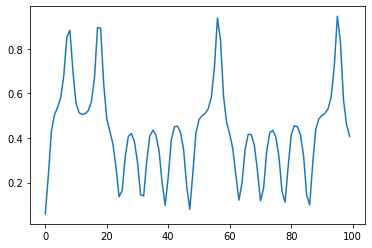

In [976]:
lst = [i for i in range(100)]
lst_y = Y1[:100]

plt.plot(lst, lst_y)

In [1293]:
heal_lst = [lst_y[30], 'N', lst_y[32], 'N', lst_y[34], lst_y[35]]
healed_lst = self_healing_window(lst_y, heal_lst)
print(healed_lst)
print(lst_y[30:35])


[0.290324534086983, 0.14494352570494598, 0.13977241628366002, 0.2961950894306572, 0.4094828745460525, 0.43506036680030186]
[0.29032453 0.14494353 0.13977242 0.29619509 0.40948287]


In [1232]:
pre = predictor_markov_chain()
pre.fit_train_array(lst_y)
pre.produce_chain_diff(30, 1, mode = 'uni')

<AxesSubplot:>

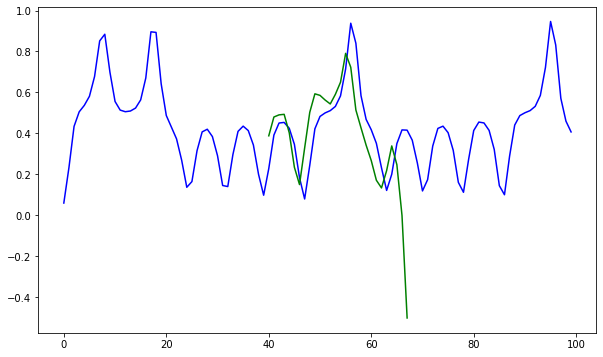

In [1356]:
non_pred_model = predictor.ForcedPredictionNPM()
a, b = pre.predict(lst_y[:40], 20, non_pred_model)

aa = []
bb = []

for i, j in zip(lst[40:(40 + len(a))], a):
    if j != 'N':
        aa.append(i)
        bb.append(j)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.lineplot(x=lst, y=lst_y, color='blue', ax=ax)
sns.lineplot(x=aa, y=bb, color='green', ax=ax)

<AxesSubplot:>

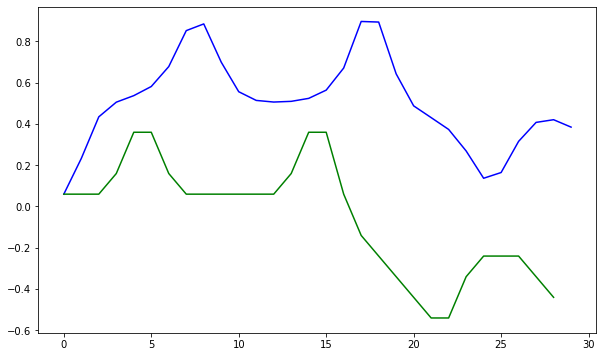

In [1126]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

test_y = pre.get_trajectory_diff(lst_y[0], 30, 1)

sns.lineplot(x=lst[:30], y=lst_y[:30], color='blue', ax=ax)
sns.lineplot(x=lst[:len(test_y)], y=test_y, color='green', ax=ax)

In [1308]:
pre2 = predictor_markov_chain()
pre2.fit_train_array(lst_y)
pre2.produce_chain_grad(30, 1, mode = 'uni')

<AxesSubplot:>

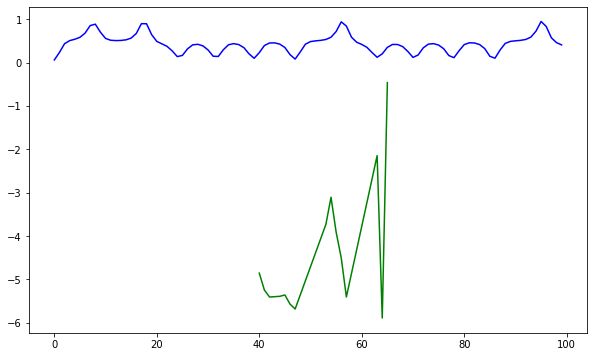

In [1350]:
non_pred_model = predictor.RapidGrowthNPM()
a, b = pre2.predict(lst_y[40:], 20, non_pred_model, alg_type='grad')

aa = []
bb = []

for i, j in zip(lst[40:(40 + len(a))], a):
    if j != 'N':
        aa.append(i)
        bb.append(j)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.lineplot(x=lst, y=lst_y, color='blue', ax=ax)
sns.lineplot(x=aa, y=bb, color='green', ax=ax)

<AxesSubplot:>

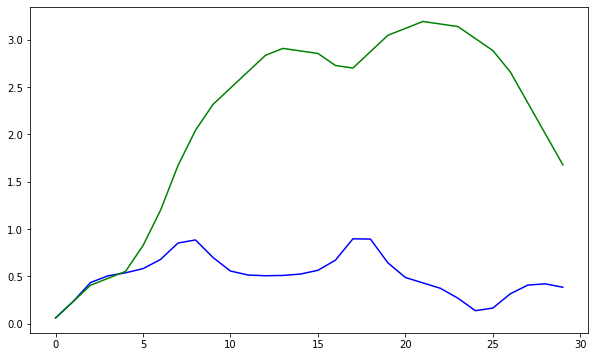

In [1284]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

test_yy = pre2.continue_trajectory_grad([lst_y[i] for i in range(5)])

sns.lineplot(x=lst[:30], y=lst_y[:30], color='blue', ax=ax)
sns.lineplot(x=lst[:len(test_yy)], y=test_yy, color='green', ax=ax)

In [1384]:
Y1[:5]

array([0.05920574, 0.23229307, 0.43391142, 0.50497904, 0.53662395])

In [1399]:
x = list(range(200))
y = Y1[1000:1200]
non_pred_model = predictor.RapidGrowthNPM()

In [1400]:
predictor_power = predictor_markov_chain()
predictor_power.fit_train_array(Y1[:1000])
predictor_power.produce_chain_diff(50, mode='ind')

100%|██████████| 950/950 [00:10<00:00, 93.20it/s] 


In [1401]:
pred_y, pos_pre_y = predictor_power.predict(y[:100], 30, non_pred_model)

In [1402]:
predictor_nopower = predictor.TimeSeriesPredictor([], non_pred_model)
cluster_motifs = predictor_nopower.cluster_motifs(Y1[:1000])

In [1405]:
prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

pred_yy, pos_pred_yy = predictor_nopower.predict(y[:100], 10, **prediction_params)

In [58]:
from time_series_prediction import main_predictor as mp
from time_series_prediction import predictor as pr

In [59]:
non_pred_model = mp.ForcedPredictionNPM()

In [60]:
pre1 = mp.predictor_markov_chain()
pre1.fit_train_array(Y1)
pre1.produce_graph(100, mode='uni')

100%|██████████| 9900/9900 [00:13<00:00, 746.25it/s]


In [ ]:
pre2 = pr.TimeSeriesPredictor([], non_pred_model)
pre2.cluster_motifs(Y1)

In [63]:
y1, py1 = pre1.predict(Y2[:20], 50, non_pred_model, up_method='db')

In [51]:
prediction_params = {
    'up_method' : 'db', # {'a', 'wi', 'db', 'op'}
    'eps' : 0.01, # max distance in cluster
    'min_samples' : 5, # min number of samples in cluster
    'alg_type' : 's', # {'s', 'tp'}
    'np_method' : 'fp'
}

pre2.set_non_pred_model = non_pred_model
y2, py2 = pre2.predict(Y2[:20], 100, **prediction_params)

In [56]:
def clean(x_array, y_array):
    x = []
    y = []
    for i, j in zip(x_array, y_array):
        if j != 'N':
            x.append(i)
            y.append(j)
    return x, y

In [81]:
labels = DBSCAN(eps=0.01, min_samples=5).fit_predict(np.array(py1[0]).reshape(-1, 1))
labels


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1], dtype=int64)